In [7]:
import itertools
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import svm
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy.stats import rankdata

%matplotlib inline

train = fetch_20newsgroups_vectorized(subset='train',remove=('headers', 'footers', 'quotes'))
test = fetch_20newsgroups_vectorized(subset='test',remove=('headers', 'footers', 'quotes'))
X_train, X_test, y_train, y_test = train.data, test.data, train.target, test.target

n_classes = np.unique(y_train).shape[0]
n_pairs = (n_classes) * (n_classes - 1)

# classify and calculate scores
# classifier = OneVsOneClassifier(MultinomialNB())
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

classifier = OneVsRestClassifier(MultinomialNB())
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# =================   ==============
# Frequentist method of estimating AUC
# =================   ==============
overall_auc = 0
indiv_m1_m2 = np.zeros(n_pairs)  # individual m1*m2
indiv_count = np.zeros(n_pairs)
indiv_auc = np.zeros(n_pairs)
names = {}
l = 0
for i, j in itertools.product(range(n_classes), range(n_classes)):
    if (i == j):
        continue

    name = 'A (' + train.target_names[i] + '|' + train.target_names[j] + ')'
    i_score = y_score[y_test == i][:, i]
    j_score = y_score[y_test == j][:, i]
    alldata = np.concatenate((i_score, j_score))
    ranked = rankdata(alldata)
    m1 = len(i_score)
    m2 = len(j_score)
    i_rank = ranked[:m1]
    j_rank = ranked[m1:]
    s = np.sum(i_rank, axis=0)
    count = s - m1 * (m1 + 1) / 2.0
    indiv_m1_m2[l] = m1 * m2
    indiv_count[l] = count
    indiv_auc[l] = float(count) / (m1 * m2)
    overall_auc += indiv_auc[l]
    names[l] = name
    l += 1
overall_auc = overall_auc / (n_classes * (n_classes - 1))
sample = 50000
burnin = 10000

with pm.Model() as model:
    hyper_alpha = pm.Exponential('hyper_alpha', lam=1)
    hyper_beta = pm.Exponential('hyper_beta', lam=1)

    p = pm.Beta('p', alpha=hyper_alpha, beta=hyper_beta, shape=n_pairs)
    n = pm.Binomial('n', n=indiv_m1_m2, p=p, observed=indiv_count, shape=n_pairs)

    step = pm.Metropolis()
    hierarchical_trace = pm.sample(sample, step, progressbar=True)

#_ = pm.traceplot(hierarchical_trace[burnin:], ['p', 'hyper_alpha', 'hyper_beta'])


combined_auc2 = np.concatenate(hierarchical_trace.get_values('p')[burnin:])


100%|██████████| 50000/50000 [00:31<00:00, 1565.48it/s]


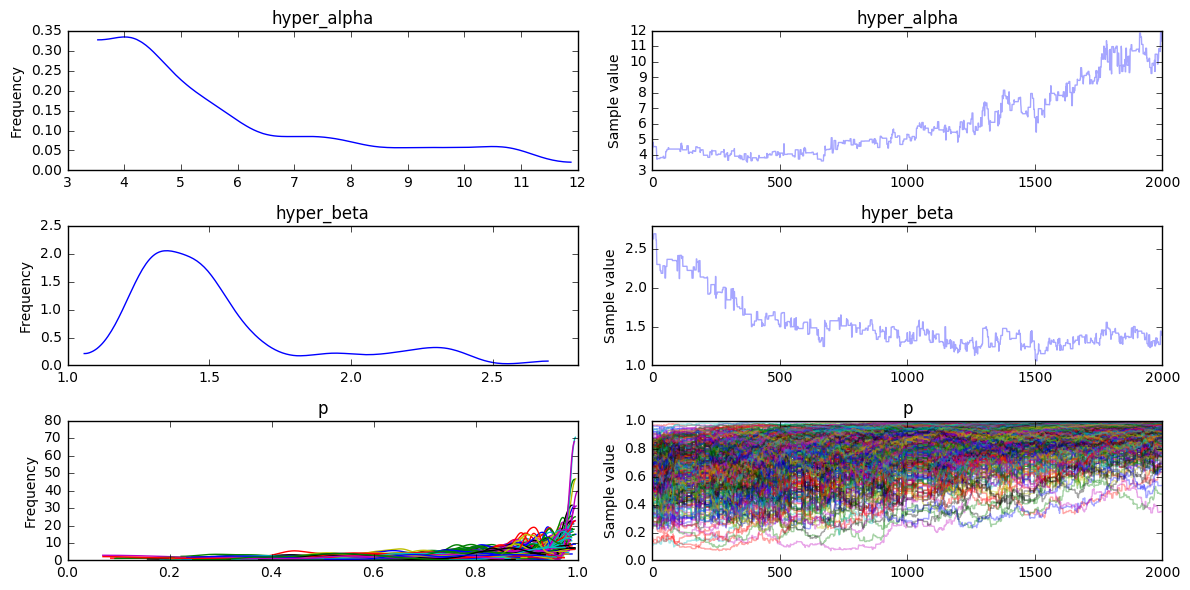

In [5]:

_ = pm.traceplot(hierarchical_trace[burnin:])


In [3]:
score = pm.geweke(np.concatenate(hierarchical_trace.get_values('p')))

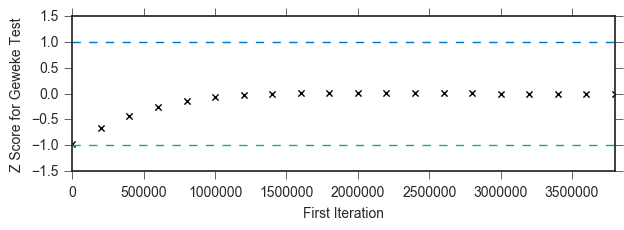

In [4]:
figure = plt.figure(figsize=(7,2))
ax = plt.subplot()
_ = ax.scatter(score[:,0],score[:,1],c='black',marker='x')
x_min = min(score[:,0])
x_max = max(score[:,0])            
_ = ax.hlines(y =[-1],xmin=x_min,xmax=x_max,colors='#1aaf5d',linestyles='dashed',linewidths=1)
_ = ax.hlines(y =[1],xmin=x_min,xmax=x_max,colors='#0075c2',linestyles='dashed',linewidths=1)
_ = ax.set_xlim([x_min,x_max])     
_ = ax.set_xlabel('First Iteration')
_ = ax.set_ylabel('Z Score for Geweke Test')
plt.show()

In [40]:
score

array([[  0.00000000e+00,  -3.26763185e-03],
       [  4.49999000e+05,  -8.15512727e-04],
       [  8.99998000e+05,  -4.42803160e-04],
       [  1.34999700e+06,  -4.67247994e-04],
       [  1.79999600e+06,  -1.43222134e-04],
       [  2.24999500e+06,   2.90233172e-05],
       [  2.69999400e+06,   2.06875270e-05],
       [  3.14999300e+06,  -1.57163891e-04],
       [  3.59999200e+06,  -2.53786614e-04],
       [  4.04999100e+06,  -2.78494829e-04],
       [  4.49999000e+06,  -1.36929936e-04],
       [  4.94998900e+06,  -1.79434735e-04],
       [  5.39998800e+06,  -1.57247329e-04],
       [  5.84998700e+06,  -6.13722555e-05],
       [  6.29998600e+06,   9.08447904e-05],
       [  6.74998500e+06,   5.78289131e-05],
       [  7.19998400e+06,  -5.58673289e-05],
       [  7.64998300e+06,  -7.08346802e-05],
       [  8.09998200e+06,  -2.14365705e-04],
       [  8.54998100e+06,  -2.90619745e-04]])

In [8]:
# colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
#           '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
# figure = plt.figure(figsize=(12,6))
# ax = figure.add_subplot(1)

# _ = ax.hist(combined_auc2, bins=100, histtype='stepfilled', color=colors[2])
# _ = ax.set_ylabel('Frequency')
# _ = ax.set_title('Posterior AUC distribution (Hierarchical model)')
# plt.show()


import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

sns.set_style('ticks')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']
lower_limits = np.round(np.sort(combined_auc2)[int(0.025 * len(combined_auc2))],decimals=3)
upper_limits = np.round(np.sort(combined_auc2)[int(0.975 * len(combined_auc2))],decimals=3)
figure = plt.figure(figsize=(8,3))
ax = plt.subplot()
vlines_height = 2000000
auc_mean = combined_auc2.mean()

_ = ax.hist(combined_auc2,alpha=.9, bins=20, 
         histtype='step', color=colors[5], 
         label='')
_hist = ax.hist(combined_auc2,alpha=.2, bins=20,
         histtype='stepfilled', color=colors[5])

_ = ax.hlines(0.1, lower_limits, upper_limits, label="95% credible region",
           color=colors[1], linewidths=4)
_ = ax.set_xlim(0,1)
_ = ax.set_ylim(0,2000000)

_ = ax.vlines(auc_mean, 0.1, vlines_height,alpha=0.5,
                  label='Bayesian AUC mean = {0:0.4f}'.format(auc_mean),
              linestyles='--', color=colors[0], linewidths=2)
_ = ax.vlines(lower_limits,  0.1, vlines_height, label="lower limits = {0:0.4f}".format(lower_limits),
           linestyles="-.", color=colors[1], linewidths=1)
_ = ax.vlines(upper_limits,  0.1, vlines_height, label="upper limits = {0:0.4f}".format(upper_limits),
           linestyles="-.", color=colors[1], linewidths=1)
_ = ax.scatter(overall_auc, 5000, label='Frequentist AUC= {0:0.4f}'.format(overall_auc)
               ,color=colors[1], marker='o',s= 50)
_ = ax.legend(loc='upper left',frameon=True)
_ = ax.set_title('Posterior AUC distribution (Hierarchical model)')


plt.show()

NameError: name 'sns' is not defined

In [6]:
len(combined_auc2)

760000

In [3]:
50000/20

2500